# Introduction

Dropout is a wide-used trick used in nerual network for preventing overfitting to predict better, apart from it, the dropout also enables us to obtain the model uncertainty. This notebook is going to discover the two main features of dropout.

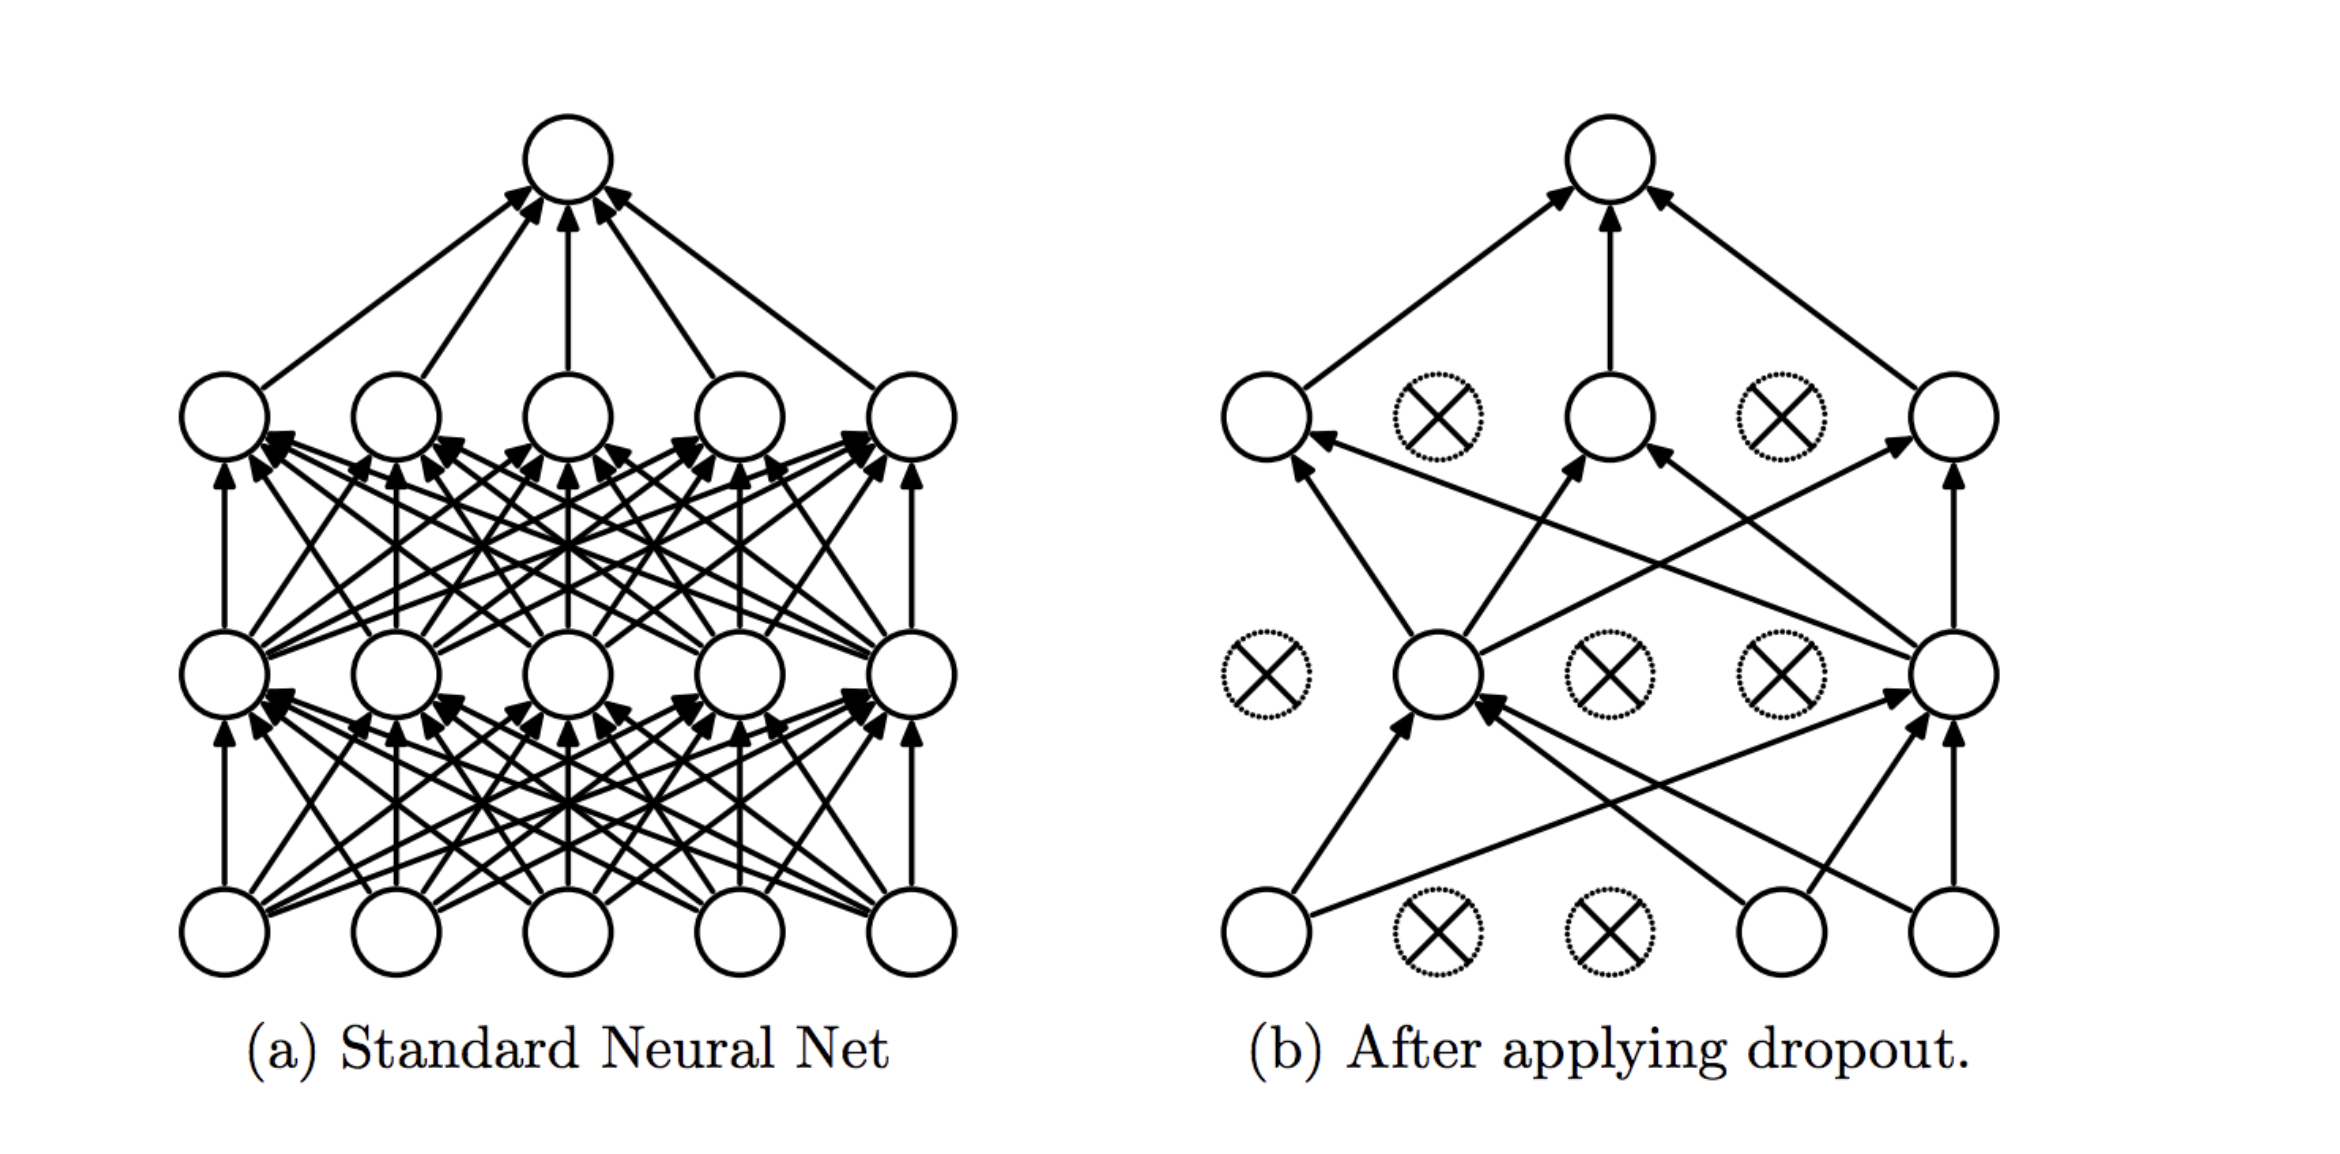

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 43518371.34it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1727794.81it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13717080.57it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8952316.15it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



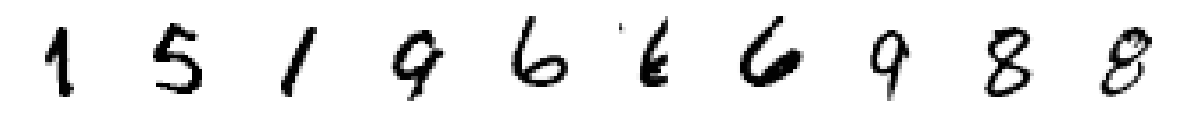

Labels: [1 5 1 9 6 6 6 9 8 8]
Image data shape: (1, 28, 28)


In [2]:
# Data transformation: Convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST datasets
trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot 10 sample images
fig, ax = plt.subplots(1, 10, figsize=(15, 1.5))
ax = ax.flatten()
img_shape = images[0].numpy().shape[1]
for i in range(10):
    ax[i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)).reshape(img_shape, -1), cmap='Greys')
    ax[i].set_axis_off()
plt.show()

print('Labels:', labels[:10].numpy())
print('Image data shape:', images[0].numpy().shape)

# Implementation

## Dropout in MLPClassifier

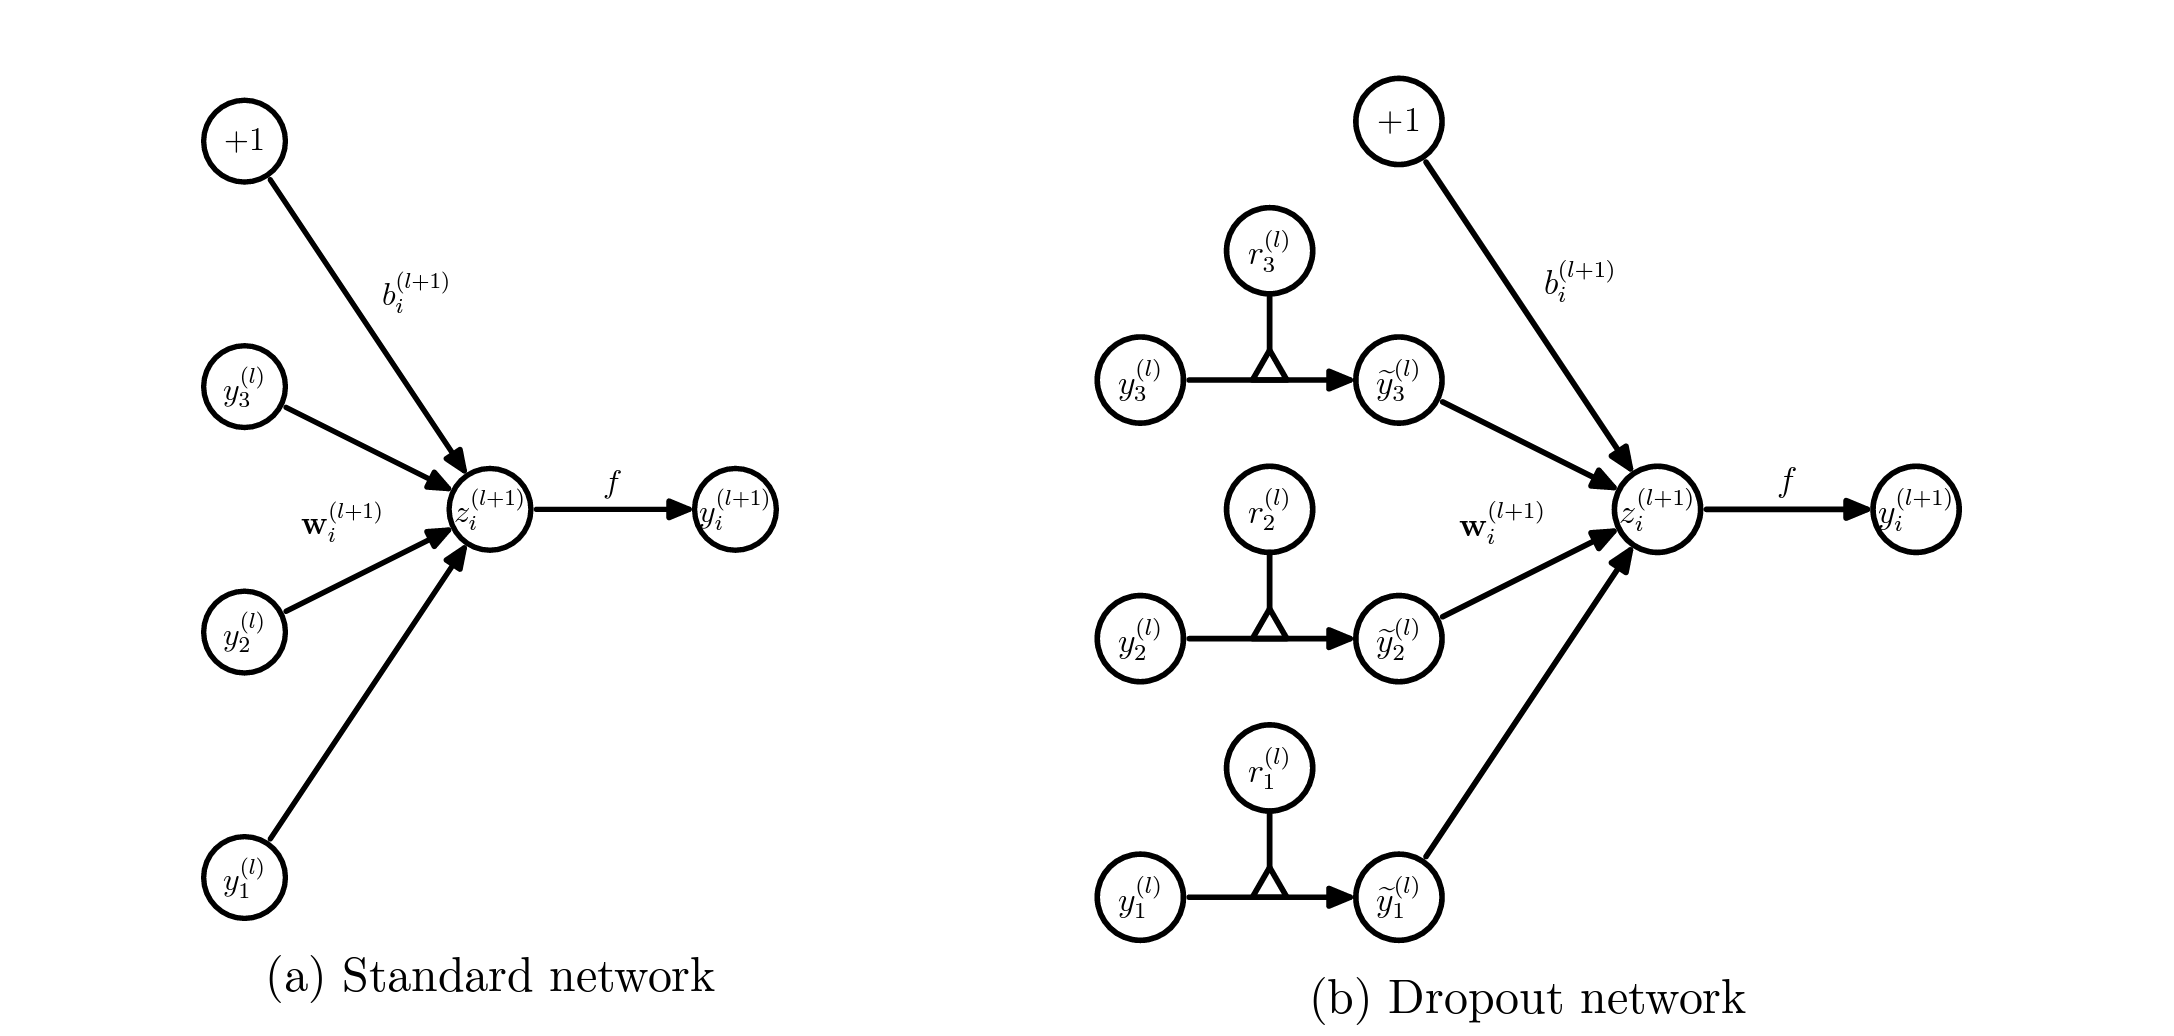

Comparison of the dropout network with the standard network for a given layer during forward propagation (Image by Nitish[1])

During the training process, we will keep or drop the neurons by the possibility $p$, but during the inference, the dropout won't be used. Therefore, it causes a problem, expected value output decreased. To solve this problem, `multiplier_` is used to scale the input to keep the same expectation

In [ ]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        self.multiplier_ = 1.0 / (1.0 - p) if p < 1 else 0.0  # Set multiplier based on dropout probability

    def forward(self, input):
        if not self.training:  # No dropout during evaluation
            return input

        # Generate dropout mask
        selected_ = torch.rand_like(input) > self.p # Uniform PDF

        return selected_.float() * input * self.multiplier_



In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_layers = [800, 800], droprates = [0, 0]):
        super().__init__()

        input_size = 28 * 28
        output_size = 10

        self.model = nn.Sequential(
            MyDropout(p=droprates[0]),
            nn.Linear(input_size, hidden_layers[0]),
            nn.Tanh(),

            MyDropout(p=droprates[1]),
            nn.Linear(hidden_layers[0], hidden_layers[1]),
            nn.Tanh(),

            nn.Linear(hidden_layers[1], output_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x.flatten(start_dim=1))

In [ ]:
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=128, max_epoch=1000, lr=0.1, momentum=0):
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates).cuda()
        self.loss_fn = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []

    def fit(self, trainset, testset, verbose=True):
        trainloader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = next(iter(testloader))
        X_test, y_test = X_test.cuda(), y_test.cuda()  # Ensure X_test and y_test are on the same device

        for epoch in range(self.max_epoch):
            running_loss = 0.0
            self.model.train()  # Set model to training mode

            for inputs, labels in trainloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                self.optimizer.zero_grad()  # Zero the parameter gradients
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                loss.backward()  # Backpropagation
                self.optimizer.step()  # Optimize weights
                running_loss += loss.item()

            self.loss_.append(running_loss / len(trainloader))  # Average loss for the epoch
            if verbose:
                print(f'Epoch {epoch+1} loss: {self.loss_[-1]}')

            self.model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                y_test_pred = self.model(X_test).max(1)[1]  # Get predictions
                accuracy = (y_test == y_test_pred).float().mean().item()
                self.test_accuracy.append(accuracy)
                self.test_error.append(int(len(testset) * (1 - accuracy)))
                if verbose:
                    print(f'Test error: {self.test_error[-1]}; test accuracy: {accuracy}')

        return self

    def predict(self, x):
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            outputs = self.model(x)
        _, pred = torch.max(outputs.data, 1)
        self.model.train()  # Set model back to training mode
        return pred

    def __str__(self):
        return f'Hidden layers: {self.hidden_layers}; dropout rates: {self.droprates}'


## Dropout in regulization

In [ ]:
# Define and train models
hidden_layers = [800, 800]
mlp_models = [
    MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=100),
    MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=100),
    MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=100)
]

# Training, uncomment to train your own model
for mlp in mlp_models:
    mlp.fit(trainset, testset, verbose=False)



In [ ]:
import os
import pickle
save_dir = '/kaggle/working/'
base_filename = 'model_'

for i, model in enumerate(mlp_models):
    save_path = os.path.join(save_dir, f'{base_filename}{i}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model {i} saved to {save_path}")

print("All models saved successfully.")

Model 0 saved to /kaggle/working/model_0.pkl
Model 1 saved to /kaggle/working/model_1.pkl
Model 2 saved to /kaggle/working/model_2.pkl
All models saved successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
base_dir = '/content/drive/MyDrive/Colab_Notebooks/ML2/Models'
base_filename = 'model_'
mlp_models = []

for i in range(3):
    load_path = os.path.join(base_dir, f'{base_filename}{i}.pkl')
    try:
        with open(load_path, 'rb') as f:
            model = pickle.load(f)
            # Ensure the model is in evaluation mode
            model.model.eval()
            # Move the model to GPU if available
            if torch.cuda.is_available():
                model.model = model.model.cuda()
            mlp_models.append(model)
        print(f"Model {i} loaded successfully from {load_path}")
    except FileNotFoundError:
        print(f"Model file not found: {load_path}")
    except Exception as e:
        print(f"Error loading model {i}: {str(e)}")

Model 0 loaded successfully from /content/drive/MyDrive/Colab_Notebooks/ML2/Models/model_0.pkl
Model 1 loaded successfully from /content/drive/MyDrive/Colab_Notebooks/ML2/Models/model_1.pkl
Model 2 loaded successfully from /content/drive/MyDrive/Colab_Notebooks/ML2/Models/model_2.pkl


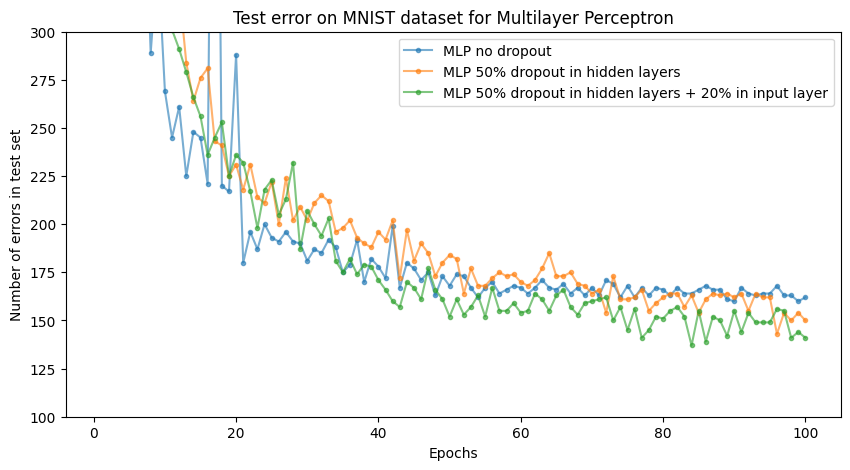

In [ ]:
# Plotting the results
labels = [
    'MLP no dropout',
    'MLP 50% dropout in hidden layers',
    'MLP 50% dropout in hidden layers + 20% in input layer'
]

plt.figure(figsize=(10, 5))
for i, mlp in enumerate(mlp_models):
    plt.plot(range(1, len(mlp.test_error) + 1), mlp.test_error, '.-', label=labels[i], alpha=0.6)
plt.ylim([100, 300])
plt.legend(loc=1)
plt.xlabel('Epochs')
plt.ylabel('Number of errors in test set')
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()

From the result, we see dropout as regularization is useful and it successfully improves the network accuracy on the test set. In addition, further adding the dropout layer after the input layer will help as well.

## Dropout in uncertainty

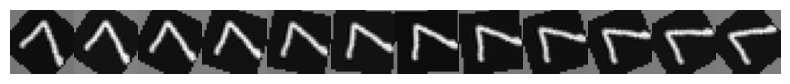

In [3]:
# Dataset Normalization
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)
# Get all test data in one batch
X_test, y_test = next(iter(testloader))

# Convert to numpy and select specific image
X_test_np = X_test.numpy()
selected_image = X_test_np[0].squeeze()

# Generate rotated versions of the image
rotation_angles = range(50, 130, 7)
X1 = np.array([rotate(selected_image, angle, reshape=False) for angle in rotation_angles])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

# Plot the rotated images
plt.figure(figsize=(8, 1))
gs = gridspec.GridSpec(1, len(X1), wspace=0, hspace=0)
for i, img in enumerate(X1.squeeze()):
    ax = plt.subplot(gs[i])
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

We simulate 1000 stochastic forward passes (with dropout still enabled) on number 7, and visualize distributions of the softmax inputs and the softmax outputs for each of the top classes.

In [ ]:
def predict(model, X, T=1000):
    X = X.cuda()
    deterministic_pred = model.predict(X)

    softmax_inputs = []
    softmax_outputs = []
    model.model.train()  # Ensure dropout is active for stochastic predictions
    for _ in range(T):
        with torch.no_grad():
            _y1 = model.model(X)  # Raw logits (softmax inputs)
            _y2 = F.softmax(_y1, dim=1)  # Probabilities (softmax outputs)
            softmax_inputs.append(_y1.cpu().numpy())
            softmax_outputs.append(_y2.cpu().numpy())
    return deterministic_pred, np.array(softmax_inputs), np.array(softmax_outputs)

In [ ]:
model = mlp_models[2]

# Prepare the input data
X1_tensor = torch.from_numpy(X1.reshape(-1, 784)).float()  # Ensure it's a float tensor

# Make predictions
y1_pred, y1_si, y1_so = predict(model, X1_tensor)
print('Predictions:\n', y1_pred)
print('Softmax_inputs:\n', y1_si[0])
print('Softmax_outputs:\n',y1_so[0])

Predictions:
 [7 7 7 7 7 7 0 0 5 5 5 5]
Softmax_inputs:
 [[ 0.62201846  2.1602771  -1.1598749   1.9874212   1.2028829  -6.18945
  -9.301019    6.1082034  -6.304095    9.814357  ]
 [ 2.5998342   0.08900977 -0.421395   -2.0335531  -1.0197533  -3.611394
  -5.145259    9.897244   -9.448757    7.8070693 ]
 [ 4.479918   -1.1744682   0.50956184 -5.3012667   1.1632262  -4.9621873
  -2.5746531   8.830677   -5.2586203   2.8566823 ]
 [ 3.2813869   0.7321641   0.88756704 -4.8926225  -1.18199     1.149009
  -2.66153     7.7742915  -8.876981    1.7647411 ]
 [ 5.3226595  -0.51838917  1.1866024  -4.041418   -1.0834016  -0.8806928
  -1.3761104   8.309406   -7.059328   -1.3610598 ]
 [ 6.238372   -2.5215213   0.43796664 -4.697916    0.13323745 -2.8022497
  -3.187644    8.095735   -4.4026194   1.6483089 ]
 [ 8.917516   -4.491891   -1.2732949  -5.726543   -2.655012    1.2607765
  -3.477862    9.060414   -6.275503    2.6830938 ]
 [ 7.8084593  -1.5606686  -1.4678907  -7.2280436  -1.7217928   3.292627
  -0.95

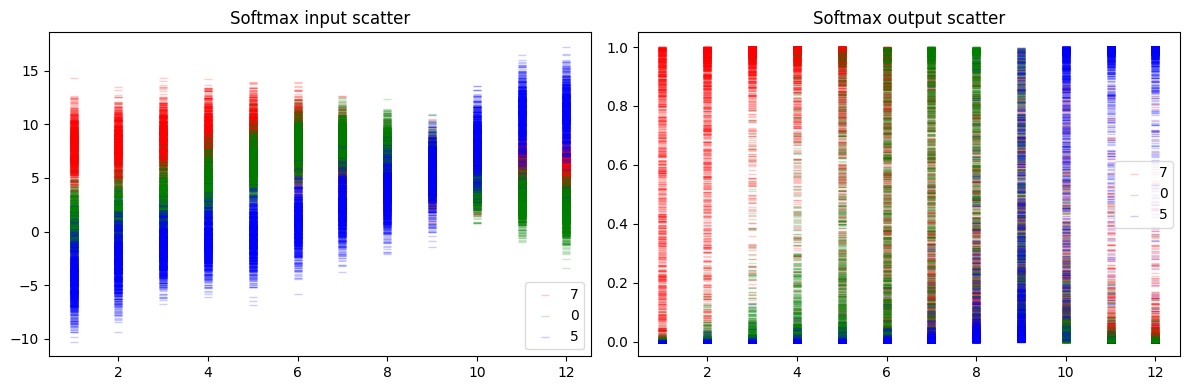

In [ ]:
plt.figure(figsize=(12, 4))
# Softmax input scatter
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(),
            color='r', marker='_', linewidth=None, alpha=0.2, label='7')
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 0].flatten(),
            color='g', marker='_', linewidth=None, alpha=0.2, label='0')
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 5].flatten(),
            color='b', marker='_', linewidth=None, alpha=0.2, label='5')
plt.title('Softmax input scatter')
plt.legend(framealpha=0.7)

# Softmax output scatter
plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(),
            color='r', marker='_', linewidth=None, alpha=0.2, label='7')
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 0].flatten(),
            color='g', marker='_', linewidth=None, alpha=0.2, label='0')
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 5].flatten(),
            color='b', marker='_', linewidth=None, alpha=0.2, label='5')
plt.title('Softmax output scatter')
plt.legend(framealpha=0.7)
plt.tight_layout()
plt.show()

The model appears most certain about the '7' predictions and least certain about some of the '5' predictions.

The graph shows that the leftmost size shows a hign confidence of output 7 but the middle, the uncertainty increases but towards the end of the optimisation when the model has converged the uncertainty decreases.

## Dropout in MLP2Regressor

In [ ]:
with h5py.File('/content/drive/MyDrive/Colab_Notebooks/ML2/co2_data.h5', 'r') as f:
    data = f['data'][:]
    labels = f['label'][:]

# Combine data and labels
data_train = np.concatenate((data, labels), axis=1)

# Reshape the data
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

# Print the shape of the combined data
print(data_train.shape)

# Generate test data
X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

(272, 2)


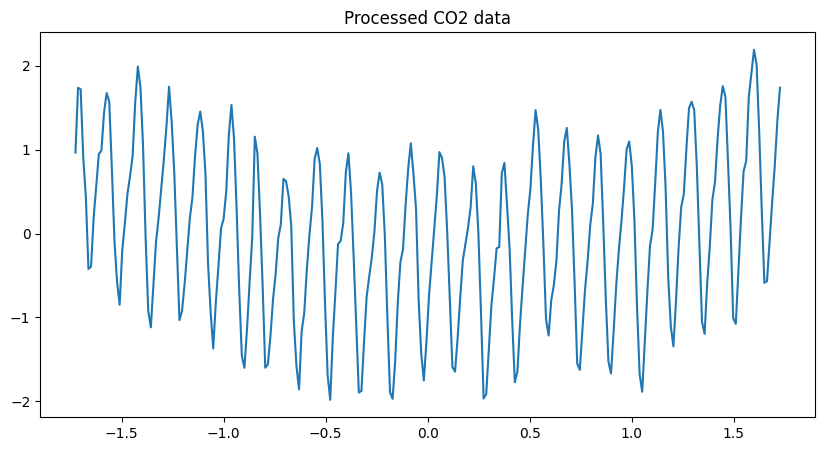

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

In [ ]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        super().__init__()

        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh()
        }

        self.model = nn.Sequential(
            nn.Linear(1, hidden_layers[0]),
            activations[activation],
            nn.Dropout(p=droprate),

            nn.Linear(hidden_layers[0], hidden_layers[1]),
            activations[activation],
            nn.Dropout(p=droprate),

            nn.Linear(hidden_layers[1], hidden_layers[2]),
            activations[activation],
            nn.Dropout(p=droprate),

            nn.Linear(hidden_layers[2], hidden_layers[3]),
            activations[activation],
            nn.Dropout(p=droprate),

            nn.Linear(hidden_layers[3], hidden_layers[4]),
            activations[activation],
            nn.Dropout(p=droprate),

            nn.Linear(hidden_layers[4], 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu',
                 max_epoch=1000, lr=0.0001, weight_decay=1e-6):
        self.hidden_layers = hidden_layers
        self.droprate = droprate
        self.activation = activation
        self.max_epoch = max_epoch
        self.lr = lr
        self.weight_decay = weight_decay
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation).cuda()
        self.loss_fn = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

    def fit(self, X_train, y_train, verbose=True):
        X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor)).cuda()
        y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor)).cuda()

        for epoch in range(self.max_epoch):
            self.model.train()
            self.optimizer.zero_grad()  # Zero the parameter gradients
            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)
            loss.backward()  # Backpropagation
            self.optimizer.step()  # Optimize weights

            if verbose and (epoch + 1) % 100 == 0:  # Print loss every 100 epochs
                print(f'Epoch {epoch+1} loss: {loss.item()}')

        return self

    def predict(self, X):
        self.model.eval()
        X = Variable(torch.from_numpy(X).type(torch.FloatTensor)).cuda()
        with torch.no_grad():
            return self.model(X).cpu().numpy()

    def __str__(self):
        return f'Hidden layers: {self.hidden_layers}; dropout rate: {self.droprate}; activation: {self.activation}'


In [ ]:
mlp2_models = [
    MLP2Regressor(activation='relu'),
    MLP2Regressor(activation='tanh')
]

# Assuming X_train and y_train are already defined and properly shaped numpy arrays
for mlp in mlp2_models:
    mlp.fit(X_train, y_train, verbose=False)

In [ ]:
import os
import pickle
save_dir = '/kaggle/working/'
base_filename = 'model_'

for i, model in enumerate(mlp2_models):
    save_path = os.path.join(save_dir, f'{base_filename}{i+3}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model {i+4} saved to {save_path}")

print("All models saved successfully.")

In [ ]:
mlp2_models = []
for i in range(3,5):
    load_path = os.path.join(base_dir, f'{base_filename}{i}.pkl')
    try:
        with open(load_path, 'rb') as f:
            model = pickle.load(f)
            # Ensure the model is in evaluation mode
            model.model.eval()
            # Move the model to GPU if available
            if torch.cuda.is_available():
                model.model = model.model.cuda()
            mlp2_models.append(model)
        print(f"Model {i} loaded successfully from {load_path}")
    except FileNotFoundError:
        print(f"Model file not found: {load_path}")
    except Exception as e:
        print(f"Error loading model {i}: {str(e)}")

Model 3 loaded successfully from /content/drive/MyDrive/Colab_Notebooks/ML2/Models/model_3.pkl
Model 4 loaded successfully from /content/drive/MyDrive/Colab_Notebooks/ML2/Models/model_4.pkl


In [ ]:
def predict_reg(model, X, T=10000):
    model.model.eval()
    X_tensor = torch.from_numpy(X).type(torch.FloatTensor).cuda()
    Yt_hat_list = []
    for _ in range(T):
        with torch.no_grad():
            y_hat = model.model(X_tensor).cpu()
        Yt_hat_list.append(y_hat)

    Yt_hat = torch.stack(Yt_hat_list)

    model.model.train()

    y_pred = model.model(X_tensor).cpu().detach().numpy()  # Point estimate prediction (single forward pass)

    return y_pred, Yt_hat.detach().numpy() # Detach Yt_hat before converting to NumPy

In [ ]:
y_relu_pred, y_relu_mc = predict_reg(mlp2_models[0], X_test)
y_relu_mc_mean = y_relu_mc.mean(axis=0)
y_relu_mc_std = y_relu_mc.std(axis=0)

y_tanh_pred, y_tanh_mc = predict_reg(mlp2_models[1], X_test)
y_tanh_mc_mean = y_tanh_mc.mean(axis=0)
y_tanh_mc_std = y_tanh_mc.std(axis=0)


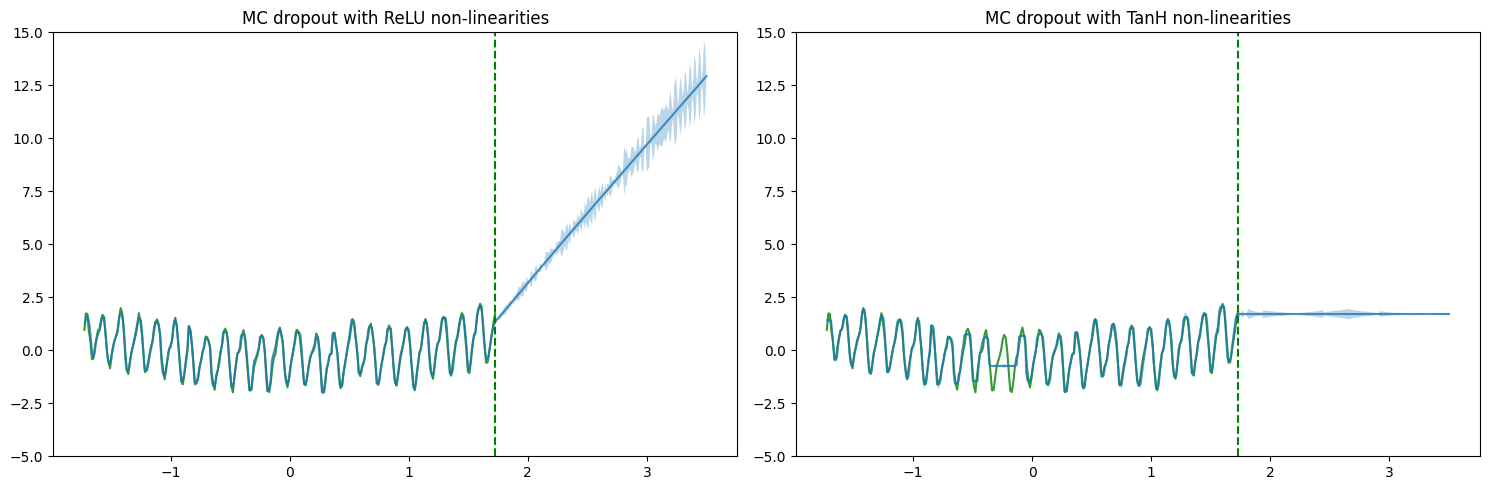

In [ ]:
plt.figure(figsize=(15, 5))
# Increase the multiplier for std dramatically and use log scale
std_multiplier = 1000  # Adjust this value as needed
log_relu_std = np.log1p(y_relu_mc_std)
log_tanh_std = np.log1p(y_tanh_mc_std)  # Use log1p to avoid log(0)


# Subplot 3: MC dropout with ReLU non-linearities
plt.subplot(1, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8)
y_relu_mean = y_relu_mc.mean(axis=0).squeeze()
plt.plot(X_test.squeeze(), y_relu_mean, alpha=0.8)
plt.axvline(X_train.squeeze()[-1], color='g', linestyle='--')
plt.fill_between(X_test.squeeze(),
                 y_relu_mean - std_multiplier * log_relu_std.squeeze(),
                 y_relu_mean + std_multiplier * log_relu_std.squeeze(),
                 alpha=0.3)
plt.title('MC dropout with ReLU non-linearities')
plt.ylim([-5, 15])

# Subplot 4: MC dropout with TanH non-linearities
plt.subplot(1, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8)
y_tanh_mean = y_tanh_mc.mean(axis=0).squeeze()
plt.plot(X_test.squeeze(), y_tanh_mean, alpha=0.8)
plt.axvline(X_train.squeeze()[-1], color='g', linestyle='--')
plt.fill_between(X_test.squeeze(),
                 y_tanh_mean - std_multiplier * log_tanh_std.squeeze(),
                 y_tanh_mean + std_multiplier * log_tanh_std.squeeze(),
                 alpha=0.3)
plt.title('MC dropout with TanH non-linearities')
plt.ylim([-5, 15])

plt.tight_layout()
plt.show()

The green dashed line is the border between train and test. During the train process, the fitting of both is almost the same but note that the uncertainty is increasing far from the data for the ReLU model, whereas for the TanH model it stays bounded. The uncertainty of dropout network with Tanh non-linearities doesn't increase far from the data, presumably because Tanh saturates whereas ReLU does not, as explained by Gal et al [2].

# Reference
[1] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, 15(1), 1929–1958. https://jmlr.csail.mit.edu/papers/volume15/srivastava14a/srivastava14a.pdf

[2] Gal, Y. &amp; Ghahramani, Z.. (2016). Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. <i>Proceedings of The 33rd International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 48:1050-1059 Available from https://proceedings.mlr.press/v48/gal16.html.

